In [20]:
!pip install matplotlib
!pip install pycore
!pip install onnx

In [17]:
!pyweed

# Earth Tuning

In [21]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        
        # Define the transformation pipeline
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        image = self.transform(image)
        
        # Assign label based on filename
        label = 1 if 'crop_6' in img_name else 0
        
        return image, label

# Usage example:
def get_data_loader(folder_path, batch_size=32, shuffle=True):
    dataset = CustomImageDataset(folder_path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Example of how to use:
if __name__ == "__main__":
    # Replace with your actual folder path
    folder_path = "earth_augment"
    
    # Create data loader
    data_loader = get_data_loader(folder_path)
    
    # Example iteration over the data loader
    for batch_images, batch_labels in data_loader:
        print(f"Batch shape: {batch_images.shape}")
        print(f"Labels shape: {batch_labels.shape}")
        break  # Just print the first batch and break

Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        
        # First convolution block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolution block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolution block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully connected layer
        # Calculate input features for FC layer
        # After three 2x2 max pools: 224 -> 112 -> 56 -> 28
        self.fc = nn.Linear(28 * 56 * 128 * 64, 2)  # 2 for binary classification

    def forward(self, x):
        # First block
        x = self.conv1(x)       # 224x224x3 -> 224x224x32
        x = F.relu(x)
        x = self.pool1(x)       # 224x224x32 -> 112x112x32
        
        # Second block
        x = self.conv2(x)       # 112x112x32 -> 112x112x64
        x = F.relu(x)
        x = self.pool2(x)       # 112x112x64 -> 56x56x64
        
        # Flatten
        x = x.view(x.size(0), -1)  # 56x56x64 -> 200704
        
        # Dropout
        x = self.dropout(x)
        
        # Fully connected layer
        x = self.fc(x)          # 200704 -> 2
        
        return x

# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {running_loss/100:.4f}, '
                      f'Accuracy: {100 * correct / total:.2f}%')
                running_loss = 0.0

# Example usage
def main():
    # Assuming you've already created your data loader as per the previous example
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create model and move to device
    model = CustomCNN().to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Assuming you have created your data_loader
    # train_loader = get_data_loader("/path/to/your/image/folder")
    
    # Train the model
    # train_model(model, train_loader, criterion, optimizer, device)

if __name__ == "__main__":
    main()

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def train_model(model, train_dataset, batch_size=32, num_epochs=10, learning_rate=0.001, 
                val_split=0.2, patience=5, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Split dataset into train and validation
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', 
                                                          factor=0.1, patience=3, verbose=True)
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    
    best_val_acc = 0
    epochs_without_improvement = 0
    
    model = model.to(device)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(train_loader, desc="Training")
        for batch_idx, (images, labels) in enumerate(train_bar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            train_bar.set_postfix({
                'loss': train_loss/(batch_idx+1), 
                'acc': 100.*train_correct/train_total
            })
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation")
            for batch_idx, (images, labels) in enumerate(val_bar):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
                val_bar.set_postfix({
                    'loss': val_loss/(batch_idx+1), 
                    'acc': 100.*val_correct/val_total
                })
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        
        # Update learning rate scheduler
        scheduler.step(val_accuracy)
        
        # Save history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)
        
        print(f"\nTrain Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
        print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        # Save best model and early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement == patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    return model, history

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non-crop_6', 'crop_6']))

# Example usage
def main():
    # Assuming you have your dataset and model defined
    # dataset = CustomImageDataset("/path/to/your/image/folder")
    # model = CustomCNN()
    
    # Example hyperparameters
    hyperparameters = {
        'batch_size': 32,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'val_split': 0.2,
        'patience': 5
    }
    
    # Train the model
    # model, history = train_model(model, dataset, **hyperparameters)
    
    # Plot training history
    # plot_training_history(history)
    
    # Create a test loader and evaluate the model
    # test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'])
    # evaluate_model(model, test_loader, device)

if __name__ == "__main__":
    main()

C:\Users\Alp\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cpu

Epoch 1/20


Validation: 100%|████████████████████████████████████████████████| 40/40 [00:15<00:00,  2.55it/s, loss=0.126, acc=98.3]



Train Loss: 0.5562, Train Acc: 95.69%
Val Loss: 0.1256, Val Acc: 98.33%

Epoch 2/20


Validation: 100%|███████████████████████████████████████████████| 40/40 [00:14<00:00,  2.81it/s, loss=0.0395, acc=99.1]



Train Loss: 0.0703, Train Acc: 99.15%
Val Loss: 0.0395, Val Acc: 99.13%

Epoch 3/20


Validation: 100%|███████████████████████████████████████████████| 40/40 [00:14<00:00,  2.72it/s, loss=0.0436, acc=98.8]



Train Loss: 0.0448, Train Acc: 99.27%
Val Loss: 0.0436, Val Acc: 98.81%

Epoch 4/20


Validation: 100%|███████████████████████████████████████████████| 40/40 [00:14<00:00,  2.73it/s, loss=0.0309, acc=99.3]



Train Loss: 0.0358, Train Acc: 99.29%
Val Loss: 0.0309, Val Acc: 99.29%

Epoch 5/20


Validation: 100%|████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.49it/s, loss=0.029, acc=99.4]



Train Loss: 0.0247, Train Acc: 99.38%
Val Loss: 0.0290, Val Acc: 99.44%

Epoch 6/20


Validation: 100%|███████████████████████████████████████████████| 40/40 [00:15<00:00,  2.51it/s, loss=0.0356, acc=99.1]



Train Loss: 0.0250, Train Acc: 99.42%
Val Loss: 0.0356, Val Acc: 99.13%

Epoch 7/20


Validation: 100%|████████████████████████████████████████████████| 40/40 [00:15<00:00,  2.58it/s, loss=0.109, acc=98.7]



Train Loss: 0.0395, Train Acc: 99.37%
Val Loss: 0.1090, Val Acc: 98.65%

Epoch 8/20


Validation: 100%|█████████████████████████████████████████████████| 40/40 [00:15<00:00,  2.53it/s, loss=0.0937, acc=99]



Train Loss: 0.0788, Train Acc: 99.01%
Val Loss: 0.0937, Val Acc: 98.97%

Epoch 9/20


Validation: 100%|███████████████████████████████████████████████| 40/40 [00:15<00:00,  2.54it/s, loss=0.0469, acc=98.8]



Train Loss: 0.0627, Train Acc: 99.01%
Val Loss: 0.0469, Val Acc: 98.81%

Epoch 10/20


Validation: 100%|███████████████████████████████████████████████| 40/40 [00:15<00:00,  2.57it/s, loss=0.0299, acc=99.3]



Train Loss: 0.0203, Train Acc: 99.48%
Val Loss: 0.0299, Val Acc: 99.29%

Early stopping triggered after 10 epochs


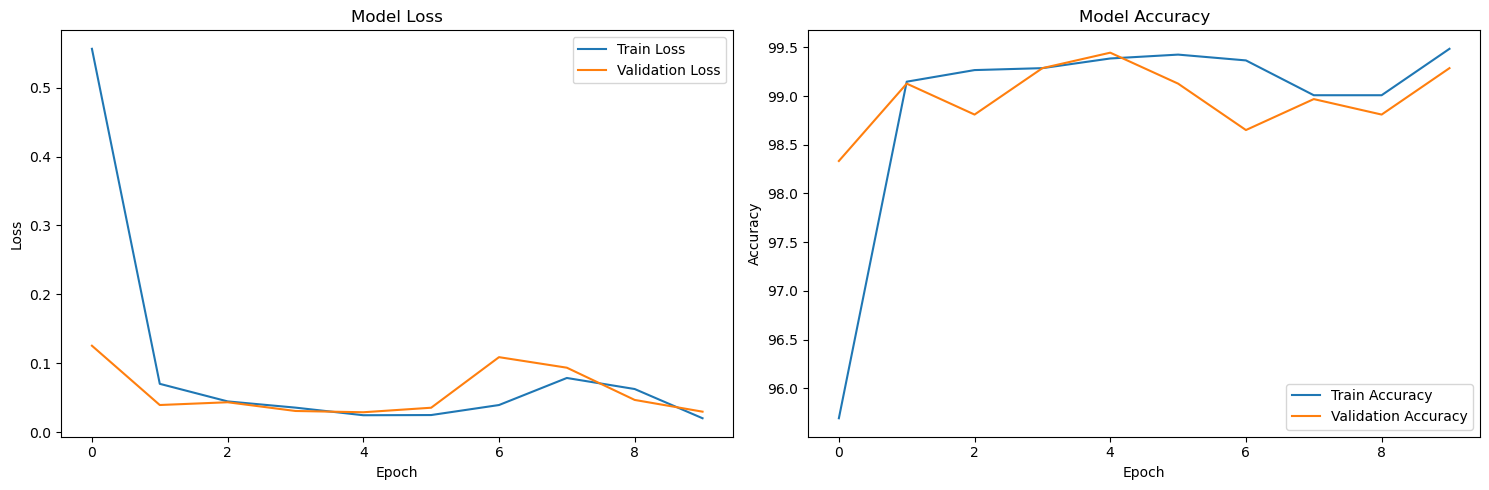

Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  2.57it/s]


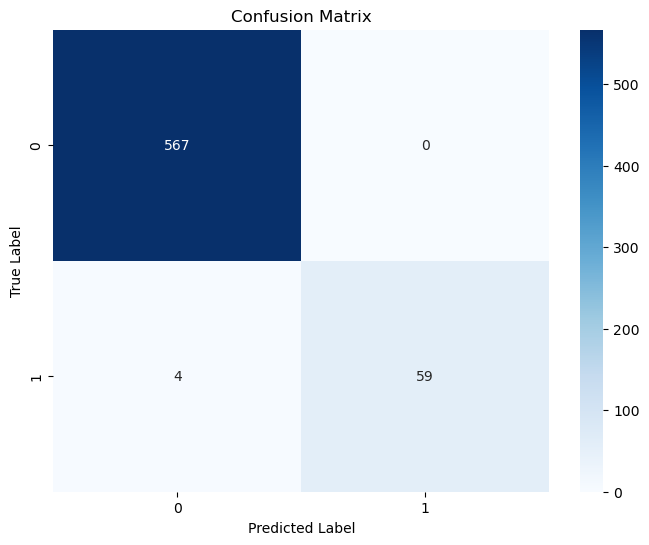


Classification Report:
              precision    recall  f1-score   support

  Non-crop_6       0.99      1.00      1.00       567
      crop_6       1.00      0.94      0.97        63

    accuracy                           0.99       630
   macro avg       1.00      0.97      0.98       630
weighted avg       0.99      0.99      0.99       630



In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming you have the CustomCNN and CustomImageDataset classes defined as before

def main():
    # Initialize dataset
    dataset = CustomImageDataset("earth_augment/")  # Replace with your actual path
    
    # Initialize model
    model = CustomCNN()
    
    # Example hyperparameters
    hyperparameters = {
        'batch_size': 32,
        'num_epochs': 20,
        'learning_rate': 0.001,
        'val_split': 0.2,
        'patience': 5
    }
    
    # Train the model
    trained_model, history = train_model(model, dataset, **hyperparameters)
    
    # Plot training history
    plot_training_history(history)
    
    # Create a small test set from the original dataset for demonstration
    # In a real scenario, you'd have a separate test set
    test_size = int(len(dataset) * 0.1)
    _, test_dataset = random_split(dataset, [len(dataset) - test_size, test_size])
    
    test_loader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.save(model.state_dict(), 'earth_tuned.pth')
    # Evaluate the model
    evaluate_model(trained_model, test_loader, device)

if __name__ == "__main__":
    main()

In [11]:
import onnx
# 2. Initialize the model
model = CustomCNN()

# 3. Load the saved model state
model.load_state_dict(torch.load("earth_tuned.pth"))

# 4. Set the model to evaluation mode (if you're doing inference)
model.eval()

# 5. Example: Running inference on a dummy input
dummy_input = torch.randn(1, 3, 224, 224)  # Same shape as training data
output = model(dummy_input)

torch.onnx.export(
    model,                # The trained model
    dummy_input,          # Dummy input to trace the model
    "seismic_model.onnx", # File name for saving ONNX model
    input_names=["Spectrogram Image"],  # Optional: input name
    output_names=["Earthquake Prob."], # Optional: output name
    #dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},  # Optional: dynamic batch size
    opset_version=11       # ONNX version (can be adjusted)
)


ImportError: DLL load failed while importing onnx_cpp2py_export: A dynamic link library (DLL) initialization routine failed.

# Lunar Tuning

In [24]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png'))]
        
        # Define the transformation pipeline
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.folder_path, img_name)
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        
        # Determine label based on filename
        label = 1 if img_name.upper().endswith('EVENT.PNG') else 0
        
        return image, label

def get_dataloader(folder_path, batch_size=32, shuffle=True, val_split=0.2):
    dataset = CustomImageDataset(folder_path)
    
    # Calculate split sizes
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    
    # Randomly split the dataset
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# Example usage
if __name__ == "__main__":
    # Replace with your actual folder path
    folder_path = "lunar_augment/"
    
    # Create dataloaders
    train_loader, val_loader = get_dataloader(folder_path)
    
    # Example iteration over training and validation sets
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Training Batch {batch_idx}")
        print(f"Image batch shape: {images.shape}")
        print(f"Labels: {labels}")
    
    for batch_idx, (images, labels) in enumerate(val_loader):
        print(f"Validation Batch {batch_idx}")
        print(f"Image batch shape: {images.shape}")
        print(f"Labels: {labels}")


Training Batch 0
Image batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Training Batch 1
Image batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0])
Training Batch 2
Image batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0])
Training Batch 3
Image batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Training Batch 4
Image batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Training Batch 5
Image batch shape: torch.Size([32, 3, 224, 224])

C:\Users\Alp\AppData\Local\Temp\ipykernel_32204\763359123.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Using device: cpu
Loaded previous model from best_model.pth

Evaluating current model on training and validation sets:


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.78it/s]


Initial Training Loss: 0.4476, Training Accuracy: 90.62%
Initial Validation Loss: 0.4239, Validation Accuracy: 91.45%

Do you want to continue training on the new dataset? (yes/no): yes

Continuing training on new dataset...


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.83it/s]



Epoch 1 - Train Loss: 0.4285, Train Accuracy: 85.69%
Validation Loss: 0.3386, Validation Accuracy: 92.11%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.79it/s]



Epoch 2 - Train Loss: 0.2854, Train Accuracy: 91.28%
Validation Loss: 0.2484, Validation Accuracy: 92.76%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.67it/s]



Epoch 3 - Train Loss: 0.2623, Train Accuracy: 92.93%
Validation Loss: 0.2321, Validation Accuracy: 92.11%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.74it/s]



Epoch 4 - Train Loss: 0.2436, Train Accuracy: 92.93%
Validation Loss: 0.2349, Validation Accuracy: 94.08%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.71it/s]



Epoch 5 - Train Loss: 0.2329, Train Accuracy: 93.59%
Validation Loss: 0.2851, Validation Accuracy: 91.45%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.76it/s]



Epoch 6 - Train Loss: 0.2331, Train Accuracy: 92.27%
Validation Loss: 0.2392, Validation Accuracy: 93.42%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.78it/s]



Epoch 7 - Train Loss: 0.2103, Train Accuracy: 93.26%
Validation Loss: 0.2502, Validation Accuracy: 91.45%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.62it/s]



Epoch 8 - Train Loss: 0.2146, Train Accuracy: 93.59%
Validation Loss: 0.2354, Validation Accuracy: 92.11%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.77it/s]



Epoch 9 - Train Loss: 0.1975, Train Accuracy: 93.75%
Validation Loss: 0.2754, Validation Accuracy: 91.45%


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.76it/s]



Epoch 10 - Train Loss: 0.1975, Train Accuracy: 94.57%
Validation Loss: 0.2341, Validation Accuracy: 93.42%


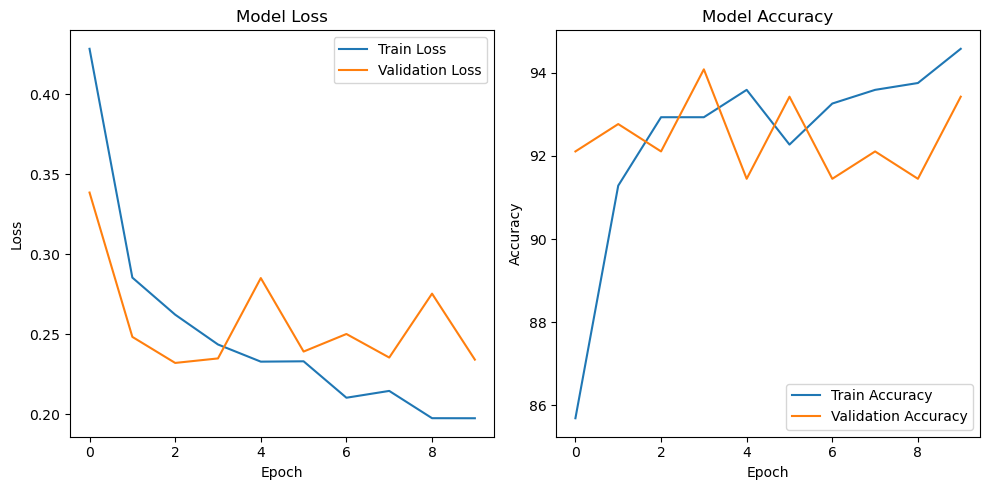


Final evaluation after continued training:


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.71it/s]

Final Training Loss: 0.1948, Training Accuracy: 93.91%
Final Validation Loss: 0.2341, Validation Accuracy: 93.42%


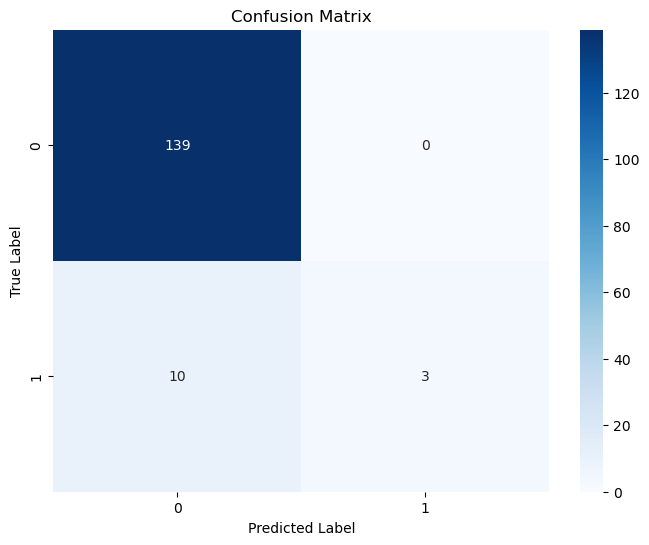


Classification Report:
              precision    recall  f1-score   support

   Non-event       0.93      1.00      0.97       139
       Event       1.00      0.23      0.38        13

    accuracy                           0.93       152
   macro avg       0.97      0.62      0.67       152
weighted avg       0.94      0.93      0.91       152



In [25]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, loader, device, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(loader)
    
    return accuracy, avg_loss, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Non-event', 'Event']))

def continue_training(model, train_loader, val_loader, criterion, optimizer, device, 
                      num_epochs=10, save_path='model_checkpoints'):
    os.makedirs(save_path, exist_ok=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (images, labels) in enumerate(train_bar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            train_bar.set_postfix({
                'loss': running_loss/(batch_idx+1), 
                'acc': 100.*correct/total
            })
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        # Validation evaluation
        val_acc, val_loss, _, _ = evaluate_model(model, val_loader, device, criterion)
        
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"\nEpoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        
        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }
        torch.save(checkpoint, f'{save_path}/model_epoch_{epoch+1}.pth')
        
    return model, history

def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load the previous model
    model = CustomCNN().to(device)
    
    # Load the saved model state if it exists
    model_path = 'best_model.pth'  # adjust path as needed
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print(f"Loaded previous model from {model_path}")
    else:
        print("No previous model found, starting with a new model")
    
    # New dataset path
    new_dataset_path = "lunar_augment/"  # adjust as needed
    
    # Create dataloaders with validation split
    batch_size = 32
    train_loader, val_loader = get_dataloader(new_dataset_path, batch_size=batch_size)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # First, evaluate the current model on the new dataset (training and validation)
    print("\nEvaluating current model on training and validation sets:")
    train_acc, train_loss, _, _ = evaluate_model(model, train_loader, device, criterion)
    val_acc, val_loss, _, _ = evaluate_model(model, val_loader, device, criterion)
    print(f"Initial Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")
    print(f"Initial Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Ask user if they want to continue training
    user_input = input("\nDo you want to continue training on the new dataset? (yes/no): ")
    torch.save(model.state_dict(), 'lunar_tuned.pth')
    
    if user_input.lower() == 'yes':
        # Continue training
        print("\nContinuing training on new dataset...")
        num_epochs = 10  # adjust as needed
        model, history = continue_training(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)
        
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train Accuracy')
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Final evaluation
        print("\nFinal evaluation after continued training:")
        train_acc, train_loss, _, _ = evaluate_model(model, train_loader, device, criterion)
        val_acc, val_loss, all_preds, all_labels = evaluate_model(model, val_loader, device, criterion)
        print(f"Final Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")
        print(f"Final Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        plot_confusion_matrix(all_labels, all_preds)

if __name__ == "__main__":
    main()


In [19]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

class ImageInference:
    def __init__(self, model_path, device=None):
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device
            
        print(f"Using device: {self.device}")
            
        # Load model
        self.model = CustomCNN().to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        
        # Define transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225])
        ])

    def process_images(self, folder_path, base_filename):
        results = []
        
        # Process images 1 through 10
        for i in range(1, 11):
            img_path = os.path.join(folder_path, f"{base_filename}_crop_{i}.png")
            
            try:
                # Check if file exists
                if not os.path.exists(img_path):
                    print(f"Warning: File not found: {img_path}")
                    continue
                
                # Load and preprocess image
                image = Image.open(img_path).convert('RGB')
                image_tensor = self.transform(image).unsqueeze(0).to(self.device)
                
                # Get prediction
                with torch.no_grad():
                    output = self.model(image_tensor)
                    probabilities = torch.nn.functional.softmax(output, dim=1)
                    event_probability = probabilities[0][1].item()  # Probability for event class
                
                results.append({
                    'path': img_path,
                    'crop_number': i,
                    'score': event_probability
                })
                
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        
        # Sort results by score
        results.sort(key=lambda x: x['score'], reverse=True)
        return results

def main():
    # Configuration
    model_path = 'lunar_tuned.pth'  # Adjust to your model path
    folder_path = 'data/S12_GradeBspecCrop/'  # Adjust to your folder path
    base_filename = 'xa.s12.00.mhz.1970-02-18HR00_evid00016_colored_spectrogram'  # Adjust to your base filename without _crop_X.png
    
    # Initialize inference
    inferencer = ImageInference(model_path)
    
    # Process images
    results = inferencer.process_images(folder_path, base_filename)
    
    # Print results
    print("\nResults (sorted by confidence):")
    print("-" * 50)
    for i, result in enumerate(results, 1):
        print(f"{i}. Crop {result['crop_number']}")
        print(f"   Score: {result['score']:.4f}")
        print(f"   Path: {result['path']}")
        print("-" * 50)
    
    # Print highest scoring image
    if results:
        highest = results[0]
        print(f"\nHighest scoring crop:")
        print(f"Crop number: {highest['crop_number']}")
        print(f"Score: {highest['score']:.4f}")
        print(f"Path: {highest['path']}")
    else:
        print("\nNo valid images were processed.")

# Example usage
if __name__ == "__main__":
    main()

Using device: cpu

Results (sorted by confidence):
--------------------------------------------------
1. Crop 5
   Score: 0.0020
   Path: data/S12_GradeBspecCrop/xa.s12.00.mhz.1970-02-18HR00_evid00016_colored_spectrogram_crop_5.png
--------------------------------------------------
2. Crop 8
   Score: 0.0019
   Path: data/S12_GradeBspecCrop/xa.s12.00.mhz.1970-02-18HR00_evid00016_colored_spectrogram_crop_8.png
--------------------------------------------------
3. Crop 2
   Score: 0.0019
   Path: data/S12_GradeBspecCrop/xa.s12.00.mhz.1970-02-18HR00_evid00016_colored_spectrogram_crop_2.png
--------------------------------------------------
4. Crop 3
   Score: 0.0018
   Path: data/S12_GradeBspecCrop/xa.s12.00.mhz.1970-02-18HR00_evid00016_colored_spectrogram_crop_3.png
--------------------------------------------------
5. Crop 4
   Score: 0.0016
   Path: data/S12_GradeBspecCrop/xa.s12.00.mhz.1970-02-18HR00_evid00016_colored_spectrogram_crop_4.png
--------------------------------------------

C:\Users\Alp\AppData\Local\Temp\ipykernel_32204\1410907184.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_locatio